# Esame Data Science - a.a. 2020/2021

Di seguitono sono proposti gli esercizi per la prova d'esame.
Per presentarsi all'esame è necessario aver implementato una soluzione per tutti e 3 gli esercizi.

1. [Esercizio Time Series](#esercizio1)
2. [Esercizio Deep Learning](#esercizio2)
3. [Esercizio Regressione Polinomiale](#esercizio3)

### Libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

<a id="esercizio1"></a>
## Esercizio TIme Series

Partiamo dai dati presi dal database Kaggle chiamato Hourly Energy Consumption. In esso sono contenuti dei dati, raccolti da PJM Interconnection, una società che coordina l'acquisto, la vendita e la consegna continua di elettricità all'ingrosso attraverso il mercato dell'energia dai fornitori ai clienti nella regione della Carolina del Sud, USA.

Tutti i file .csv contengono righe con un timestamp e un valore. Il nome della colonna del valore corrisponde al nome del contraente. Il timestamp rappresenta una singola ora e il valore rappresenta l'energia totale, consumata durante quell'ora.

https://www.kaggle.com/robikscube/hourly-energy-consumption

Leggendo il dataset `data/PJME_hourly.csv`, caricare i dati del consumo elettrico. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza).

Infine provare a usare ARIMA per predire il consumo nei prossimi 240 periodi.

In [2]:
df = pd.read_csv('data/PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
#print(type(df.index))
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


### Data preprocessing

In [3]:
#some errors are caused by duplicated index
print(df[df.index.duplicated()])
df.shape

                     PJME_MW
Datetime                    
2014-11-02 02:00:00  23755.0
2015-11-01 02:00:00  21171.0
2016-11-06 02:00:00  21692.0
2017-11-05 02:00:00  20666.0


(145366, 1)

In [4]:
#remove duplicated index
df = df[~df.index.duplicated(keep='first')]
df.shape

(145362, 1)

In [5]:
#print some statistics 
df.describe()

,PJME_MW
count,145362.000000
mean,32080.505139
std,6463.874131
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [6]:
# some problem are caused by the none frequency
print('inferred frequency: '+str(df.index.inferred_freq))
print('frequqncy: '+str(df.index.freq))

inferred frequency: None
frequqncy: None


In [7]:
#set hourly frequency
#NB: since time is not continuous some missing value will be added to series
df=df.asfreq('H')


In [8]:
#check for null values
df.isnull().sum()

PJME_MW    27
dtype: int64

In [9]:
#substitute null values with mean values
df=df.fillna(df.mean())
df.isnull().sum()

PJME_MW    0
dtype: int64

In [10]:
#check correct frequency
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=131544, freq='H')

### Plot time series

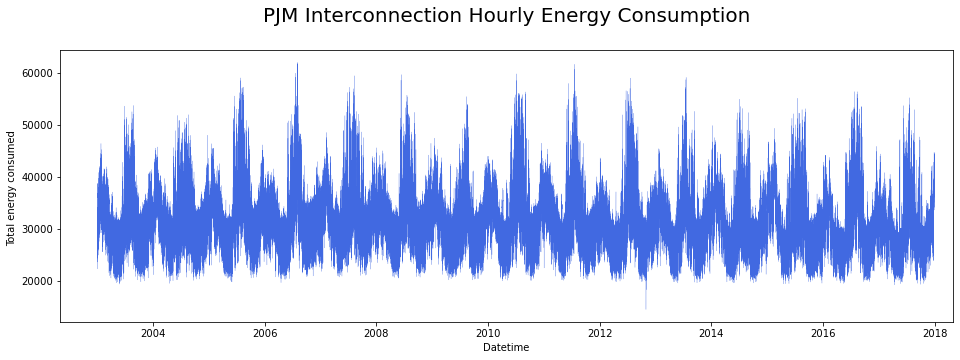

In [11]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df.PJME_MW, color='royalblue', linewidth=0.2)
plt.title('PJM Interconnection Hourly Energy Consumption\n', size= 20)
plt.ylabel('Total energy consumed ')
plt.xlabel('Datetime')
plt.xlim(left=pd.Timestamp("2002-05-01 01:00:00"), right=pd.Timestamp("2018-05-01 00:00:00 ") )
plt.show()

### Seasonal components plots

Text(0.5, 1.0, 'Yearly mean consumption\n')

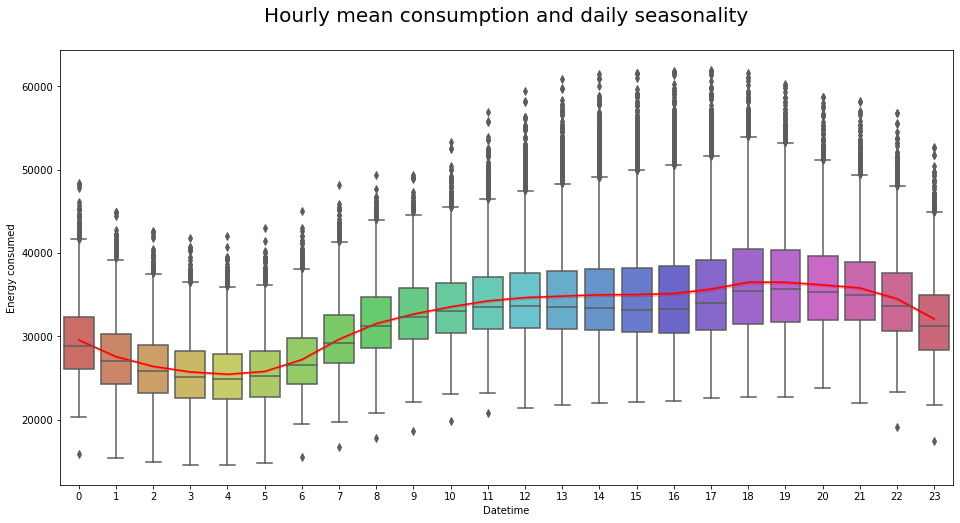

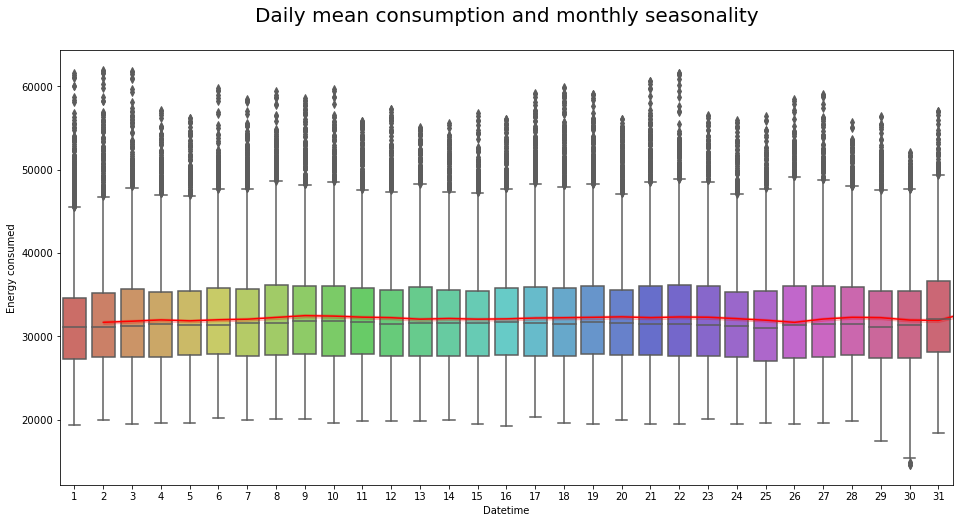

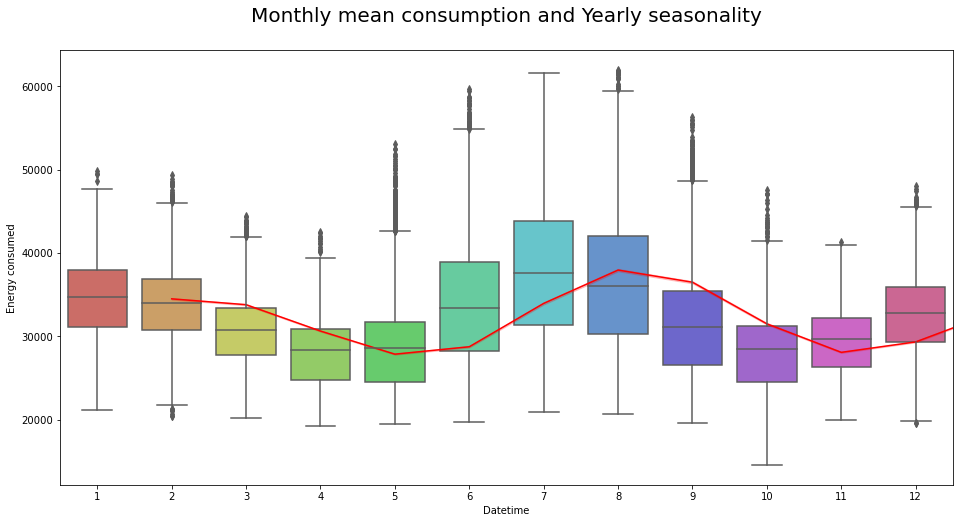

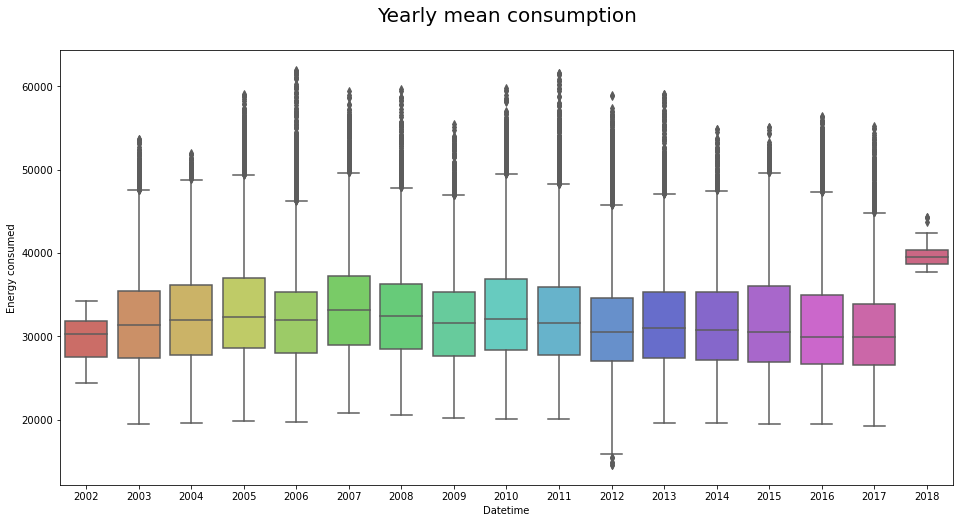

In [12]:
plt.figure(figsize=(16,8))
sns.lineplot(df.index.hour, df.PJME_MW, color='r')
sns.boxplot(df.index.hour, df.PJME_MW, palette='hls')
plt.ylabel('Energy consumed')
plt.title('Hourly mean consumption and daily seasonality\n', size=20)

plt.figure(figsize=(16,8))
sns.lineplot(df.index.day, df.PJME_MW, color='r')
sns.boxplot(df.index.day, df.PJME_MW, palette='hls')
plt.ylabel('Energy consumed')
plt.title('Daily mean consumption and monthly seasonality\n', size=20)

plt.figure(figsize=(16,8))
sns.lineplot(df.index.month, df.PJME_MW, color='r')
sns.boxplot(df.index.month, df.PJME_MW, palette='hls')
plt.ylabel('Energy consumed')
plt.title('Monthly mean consumption and Yearly seasonality\n', size=20)

plt.figure(figsize=(16,8))
sns.lineplot(df.index.year, df.PJME_MW, color='r')
sns.boxplot(df.index.year, df.PJME_MW, palette='hls')
plt.ylabel('Energy consumed')
plt.title('Yearly mean consumption\n', size=20)

### Trend Regression

In [13]:
#create a NumPy array to fit the x-axis values in the linear regression model.
x = np.arange(df.index.size)

In [14]:
# Fit the linear regression using np.polyfit and get slope and intercept values.
#As it is linear regression deg (degree) parameter is 1.

fit = np.polyfit(x, df.PJME_MW, deg=1)
print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))

Slope : -0.013811753082405754
Intercept : 33035.93739998418


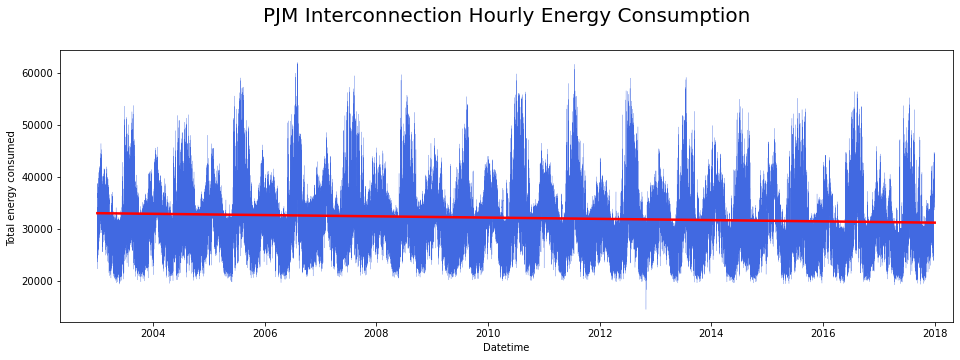

In [15]:
fit_function = np.poly1d(fit)

plt.figure(figsize=(16,5))
plt.plot(df.index, df.PJME_MW, color='royalblue', linewidth=0.2)
#Linear regression plot
plt.plot(df.index, fit_function(x), color='r', linewidth=2.5)

plt.title('PJM Interconnection Hourly Energy Consumption\n', size= 20)
plt.ylabel('Total energy consumed ')
plt.xlabel('Datetime')
plt.xlim(left=pd.Timestamp("2002-05-01 01:00:00"), right=pd.Timestamp("2018-05-01 00:00:00 ") )
plt.show()




#### Stationarity test, ACF, PACF and integration

In [16]:
# the more ADF test is negativa, the more probably the series is stationary
result = adfuller(df.PJME_MW)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -18.762594
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


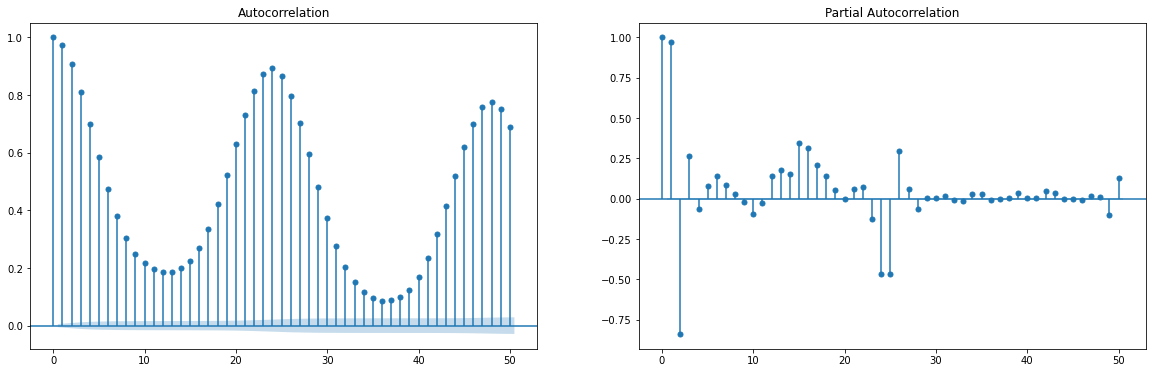

In [17]:
#attention, lag start at lag 0
#NB: consider from the number 1
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.PJME_MW.tolist(), lags=50, 
         ax=axes[0])


plot_pacf(df.PJME_MW.tolist(), lags=50, ax=axes[1])
plt.show()

Dicky fuller indicates that the series is stationary, however the ACF does not rapidly drop to zero, indeed it never reaches zero. The results of this statistic tell us that the series obtained is stationary with a significance level of less than 1%.

The series appears to be stationary on average but not in variance, in fact the daily and annual seasonality makes the variance not constant as time changes.

Differences between lag 1 and lag 24 (1 day)  are made.




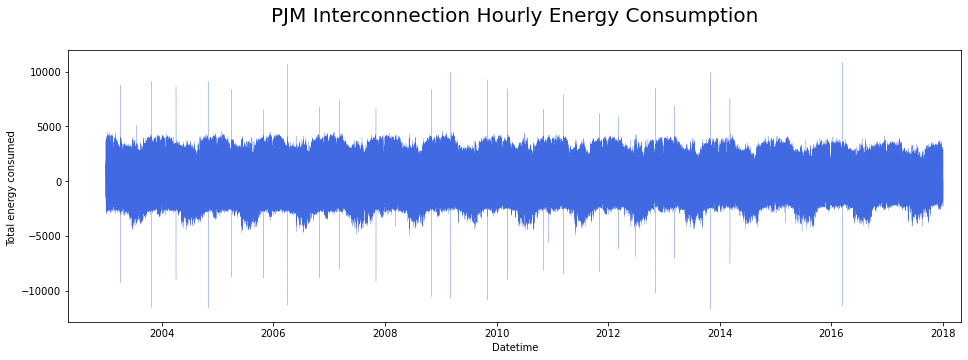

In [18]:
#remove 1 lag
diff=df.diff(1)

fit_function = np.poly1d(fit)

plt.figure(figsize=(16,5))
plt.plot(diff.index, diff.PJME_MW, color='royalblue', linewidth=0.2)


plt.title('PJM Interconnection Hourly Energy Consumption\n', size= 20)
plt.ylabel('Total energy consumed ')
plt.xlabel('Datetime')
plt.xlim(left=pd.Timestamp("2002-05-01 01:00:00"), right=pd.Timestamp("2018-05-01 00:00:00 ") )
plt.show()

In [19]:
diff=diff.dropna()
result = adfuller(diff.PJME_MW)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -52.607929
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


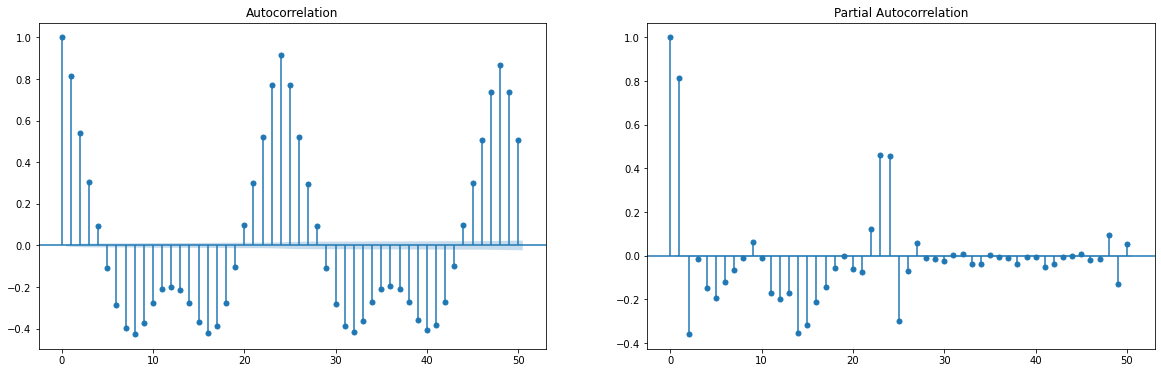

In [20]:
#attention, lag start at lag 0
#NB: consider from the first
diff=diff.dropna()
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(diff.PJME_MW.tolist(), lags=50, ax=axes[0])


plot_pacf(diff.PJME_MW.tolist(), lags=50, ax=axes[1])
plt.show()

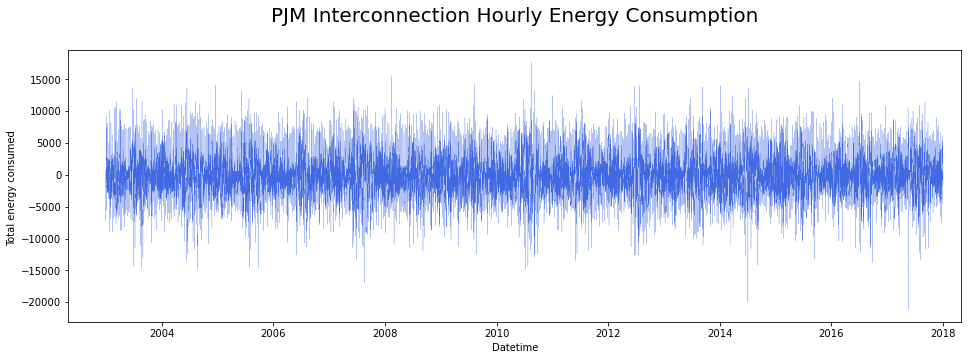

In [21]:
#remove daily seasonality (24 lag)
diff=df.diff(24)

fit_function = np.poly1d(fit)

plt.figure(figsize=(16,5))
plt.plot(diff.index, diff.PJME_MW, color='royalblue', linewidth=0.2)


plt.title('PJM Interconnection Hourly Energy Consumption\n', size= 20)
plt.ylabel('Total energy consumed ')
plt.xlabel('Datetime')
plt.xlim(left=pd.Timestamp("2002-05-01 01:00:00"), right=pd.Timestamp("2018-05-01 00:00:00 ") )
plt.show()


In [22]:
diff=diff.dropna()
result = adfuller(diff.PJME_MW)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -50.172216
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


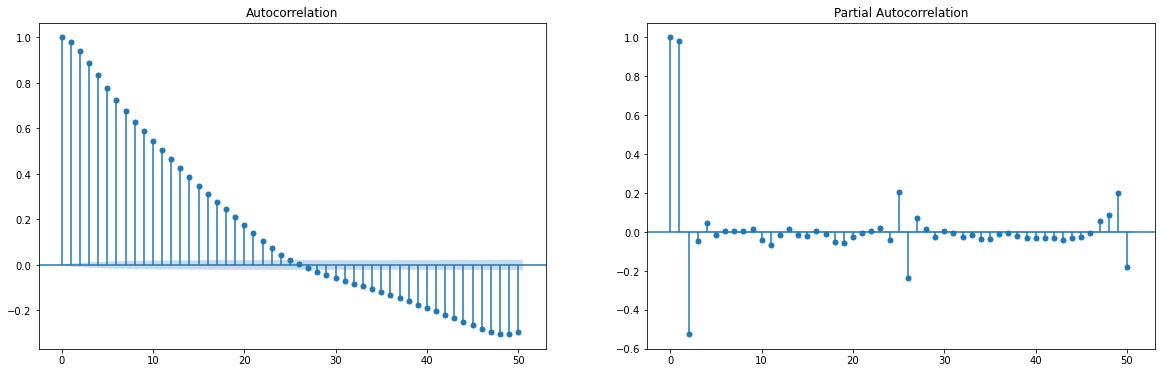

In [23]:
#attention, lag start at lag 0
#NB: consider from the first
diff=diff.dropna()
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(diff.PJME_MW.tolist(), lags=50, ax=axes[0])


plot_pacf(diff.PJME_MW.tolist(), lags=50, ax=axes[1])
plt.show()

A single integration is sufficient to make the series stationary in variance. Dicky fuller drops by more than double.
The plot of the daily integrated series looks like that of a white noise. Daily integration seems unnecessary, in fact the ACF chart drops to zero much more slowly than the normal series.
Therefore, 1 integration is considered sufficient to make the series stationary even in variance.

The ACF of this series suggests a value for the MA part of 3 or 4, in fact the k values other than zero are considered, without counting lag0 (correlation of the value with the value itself).

The PACF indicates the AR part of the model, in this case AR 2 (because lag 0 is not counted)

Therefore ARIMA (3,1,3) or ARIMA (3,1,4) model are tested.

#### ARIMA

In [24]:
#NB: for memory problem dataset is truncateed
df_truncated = df['2015-01-01 00:00:00':]

In [25]:
#3,0,3 model without integration
model_303 = ARIMA(df_truncated.PJME_MW, order=(3,0,3))
model_fit_303 = model_303.fit()
print(model_fit_303.summary())

                              ARMA Model Results                              
Dep. Variable:                PJME_MW   No. Observations:                26329
Model:                     ARMA(3, 3)   Log Likelihood             -206616.173
Method:                       css-mle   S.D. of innovations            619.183
Date:                Thu, 02 Sep 2021   AIC                         413248.345
Time:                        16:49:20   BIC                         413313.772
Sample:                    01-01-2015   HQIC                        413269.469
                         - 01-02-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.124e+04    629.320     49.645      0.000       3e+04    3.25e+04
ar.L1.PJME_MW     2.7559      0.004    635.467      0.000       2.747       2.764
ar.L2.PJME_MW    -2.5998      0.008   -3

In [26]:
#3,1,3 
model_313 = ARIMA(df_truncated.PJME_MW, order=(3,1,3))
model_fit_313 = model_313.fit()
print(model_fit_313.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.PJME_MW   No. Observations:                26328
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -205753.641
Method:                       css-mle   S.D. of innovations            599.436
Date:                Thu, 02 Sep 2021   AIC                         411523.281
Time:                        16:49:53   BIC                         411588.708
Sample:                    01-01-2015   HQIC                        411544.405
                         - 01-02-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2237      5.009      0.045      0.964      -9.594      10.041
ar.L1.D.PJME_MW     2.4749      0.007    350.255      0.000       2.461       2.489
ar.L2.D.PJME_MW    -2.0620      

In [27]:
#3,1,4
model_314 = ARIMA(df_truncated.PJME_MW, order=(3,1,4))
model_fit_314 = model_314.fit()
print(model_fit_314.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.PJME_MW   No. Observations:                26328
Model:                 ARIMA(3, 1, 4)   Log Likelihood             -205643.726
Method:                       css-mle   S.D. of innovations            596.938
Date:                Thu, 02 Sep 2021   AIC                         411305.451
Time:                        16:50:27   BIC                         411379.057
Sample:                    01-01-2015   HQIC                        411329.216
                         - 01-02-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2219      4.794      0.046      0.963      -9.175       9.619
ar.L1.D.PJME_MW     2.3130      0.015    159.007      0.000       2.284       2.341
ar.L2.D.PJME_MW    -1.7510      

The best model seems to be the ARIMA model (3,1,4), in fact it obtains better results in terms of AIC and BIC.
All the coefficients associated with the AR and MA part are significant (pvalue less than 0.05) 

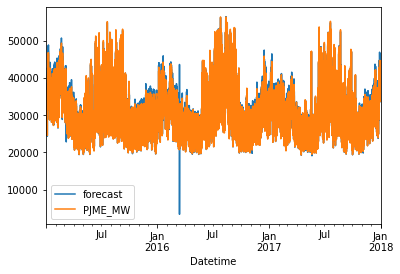

In [28]:
# PLOT Actual vs Fitted
model_fit_314.plot_predict(dynamic=False)
plt.show()

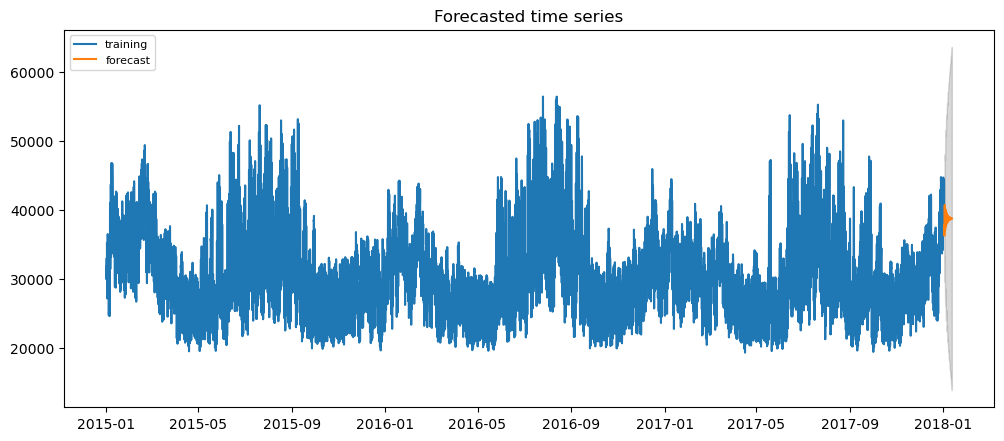

In [29]:
model = ARIMA(df_truncated, order=(3, 1, 4))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(240, alpha=0.05)  # 95% conf

# Make as pandas series
index=pd.date_range(df_truncated.index[-1], periods=240+1,freq='H')[1:]
fc_series = pd.Series(fc, index=index)
lower_series = pd.Series(conf[:, 0], index=index)
upper_series = pd.Series(conf[:, 1], index=index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_truncated, label='training')
#plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasted time series')
plt.legend(loc='upper left', fontsize=8)

plt.show()





<a id="esercizio2"></a>
## Esercizio Deep Learning

Creare una rete neurale Deep Learning per predire se un paziende ha una malattia cardiaca o no. Utilizziamo i dati presenti nel dataset linkato qui: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

E disponibile nel file `data/heart.csv`, esploriamo il dataset e proviamo a creare una rete come descritto con Tensorflow.

In [30]:
df = pd.read_csv('data/heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Data exploration

In [31]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [32]:
#transform categorical variables
category_list=['sex','cp','fbs', 'restecg','exang','slope','ca','thal','target']
for el in category_list:
    df[el] = df[el].astype('category')
df.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
target      category
dtype: object

In [33]:
df.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


<AxesSubplot:title={'center':'Distribution of continuous variables'}, ylabel='Density'>

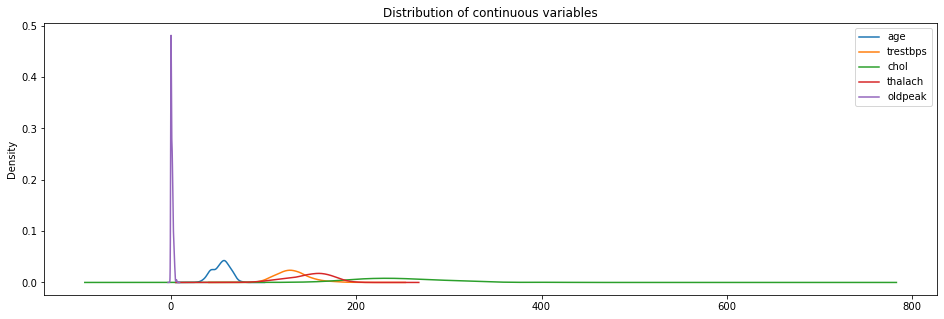

In [34]:
df.plot.kde(figsize=(16,5),title='Distribution of continuous variables')

In [35]:
#check target distribution
#NB: it shoud be balanced
print('target distribution %:\n'+str(df.target.value_counts() / len(df)))


target distribution %:
1    0.544554
0    0.455446
Name: target, dtype: float64


Continuous variables shoud be standardize because standardizing makes it easier to compare scores, like in this case when variables have scores measured on different scales.

Target variable is equally distribuited along classes, so no resampling technique is needed.

### Preoprocessing e Train test split

In [36]:
#list for cols to scale
cols_to_scale = ['age','trestbps','chol','thalach','oldpeak']

#create and fit scaler
scaler = StandardScaler()
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])

<AxesSubplot:title={'center':'Distribution of continuous variables scaled'}, ylabel='Density'>

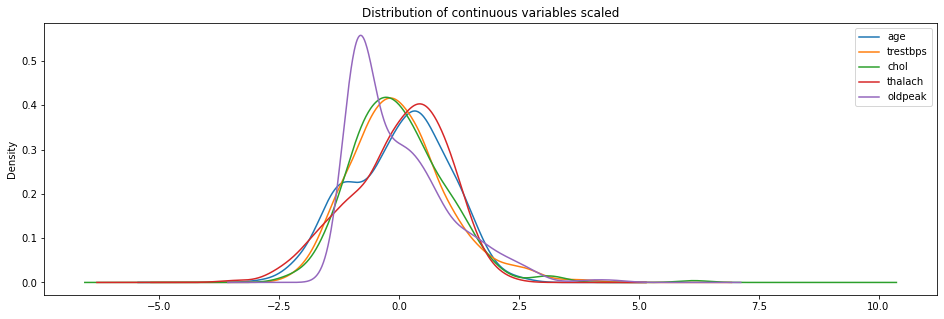

In [37]:
df.plot.kde(figsize=(16,5),title='Distribution of continuous variables scaled')

In [38]:
#select target and varibales
X=df.iloc[:, :-1] 
y = df['target']


In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
#Encode target labels with value between 0 and n_classes-1
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)


### Model training

In [41]:
#check input dim
x_train.shape

(242, 13)

In [42]:
#define model
model = Sequential()

model.add(Dense(10, input_dim=13, activation='ReLU'))
model.add(Dense(units=5, activation='ReLU'))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [43]:
#set early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001)

history = model.fit(x_train,
                    y_train,
                    epochs=100, 
                    batch_size=30,
                    verbose=1, # switch to 0 for less verbosity 
                    callbacks=[early_stopping], 
                    validation_data=(x_test, y_test))

Epoch 1/100
9/9 [==============================] - 2s 66ms/step - loss: 0.8762 - accuracy: 0.5537 - val_loss: 0.7759 - val_accuracy: 0.6066
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.8020 - accuracy: 0.5661 - val_loss: 0.7460 - val_accuracy: 0.6066
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 0.7717 - accuracy: 0.5579 - val_loss: 0.7197 - val_accuracy: 0.6066
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.7477 - accuracy: 0.5661 - val_loss: 0.6947 - val_accuracy: 0.6066
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 0.7237 - accuracy: 0.5826 - val_loss: 0.6718 - val_accuracy: 0.6393
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.6991 - accuracy: 0.5992 - val_loss: 0.6509 - val_accuracy: 0.6393
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6779 - accuracy: 0.6240 - val_loss: 0.6388 - val_accuracy: 0.6393
Epoch 8/100
9/9 [=========

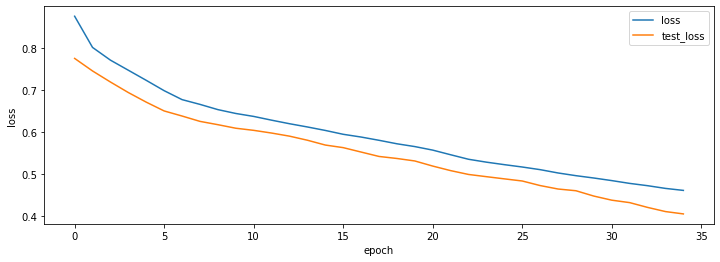

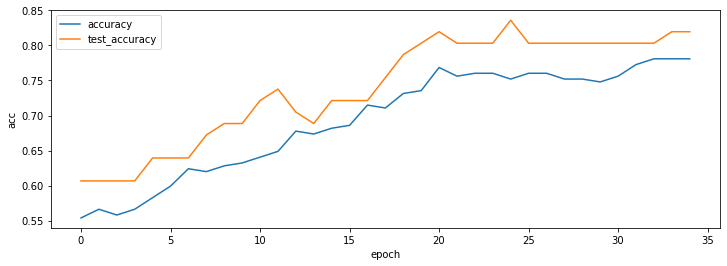

In [44]:
# plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# plot accuracy vs epoch
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

accuracy on test:0.819672131147541


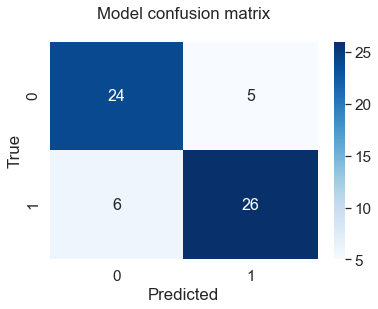

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = (model.predict(x_test).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
confusion_matrix = confusion_matrix(y_test, y_pred)

print('accuracy on test:'+str(accuracy_score(y_test, y_pred)))
sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},cmap="Blues") # font size
plt.title('Model confusion matrix\n')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model obtained reaches a final accuracy of 81%. 

<a id="esercizio3"></a>
## Esercizio regressione polinomiale

Leggendo il dataset `data/position_salaries.csv` effettuare una regressione dei dati di salario in base al livello (espresso nella forma di anni di esperienza).

In [46]:
df = pd.read_csv('data/position_salaries.csv')
df

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000
5,Region Manager,6,150000
6,Partner,7,200000
7,Senior Partner,8,300000
8,C-level,9,500000
9,CEO,10,1000000


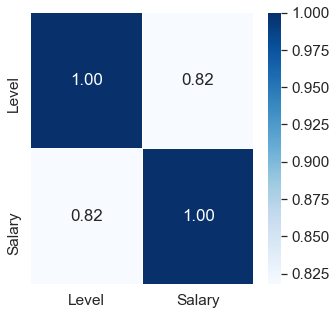

In [47]:
#check correlation
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.05, fmt='.2f', cmap=plt.cm.Blues)
plt.show()

Text(0.5, 1.0, 'Salary vs Level ')

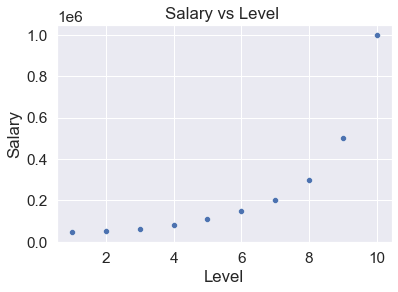

In [48]:
#pot variables
sns.scatterplot(x=df.Level, y=df.Salary)
plt.title('Salary vs Level ')

### First degree polonomy (regression line)

In [67]:
#set 
x = np.arange(df.index.size)
fit = np.polyfit(x, df.Salary, deg=1)
print ("1st degree coefficent : " + str(fit[0]/100000))
print ("Intercept : " + str(fit[1]/100000))

fit

1st degree coefficent : 0.8087878787878786
Intercept : -1.144545454545453


array([  80878.78787879, -114454.54545455])

Text(0.5, 1.0, 'Salary vs Level ')

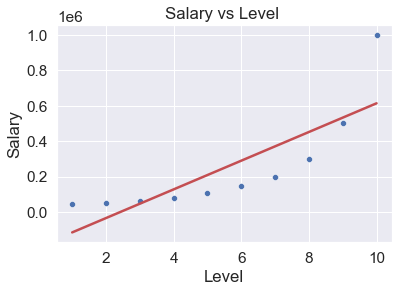

In [50]:
fit_function = np.poly1d(fit)

sns.scatterplot(x=df.Level, y=df.Salary)
sns.lineplot(x=df.Level, y=fit_function(x), color='r', linewidth=2.5)
plt.title('Salary vs Level ')

In [51]:
print("r_square score (train): %.4f" % r2_score(df.Salary,fit_function(x)))


r_square score (train): 0.6690


### Second degree polomony (parable)

In [52]:
fit = np.polyfit(x, df.Salary, deg=2)
print ("1st degree coefficent : " + str(fit[0]/1000000))
print ("2nd degree coefficent : " + str(fit[1]/1000000))
print ("Intercept : " + str(fit[2]/1000000))

1st degree coefficent : 0.019431818181818192
2nd degree coefficent : -0.09400757575757582
Intercept : 0.11872727272727278


Text(0.5, 1.0, 'Salary vs Level ')

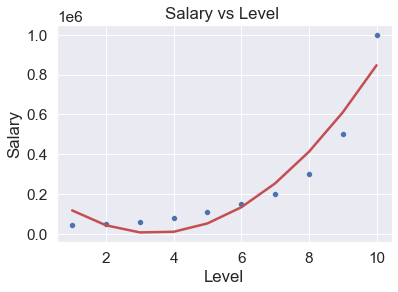

In [53]:
fit_function = np.poly1d(fit)

sns.scatterplot(x=df.Level, y=df.Salary)
sns.lineplot(x=df.Level, y=fit_function(x), color='r', linewidth=2.5)
plt.title('Salary vs Level ')

In [54]:

print("r_square score (train): %.4f" % r2_score(df.Salary,fit_function(x)))

r_square score (train): 0.9162


### Third degree polonomy

In [55]:
fit = np.polyfit(x, df.Salary, deg=3)
print ("1st degree coefficent : " + str(fit[0]/1000000))
print ("2nd degree coefficent : " + str(fit[1]/1000000))
print ("3rd degree coefficent : " + str(fit[2]/1000000))
print ("Intercept : " + str(fit[3]/1000000))

1st degree coefficent : 0.0041200466200466196
2nd degree coefficent : -0.036188811188811114
3rd degree coefficent : 0.09592657342657297
Intercept : 0.014902097902098394


Text(0.5, 1.0, 'Salary vs Level ')

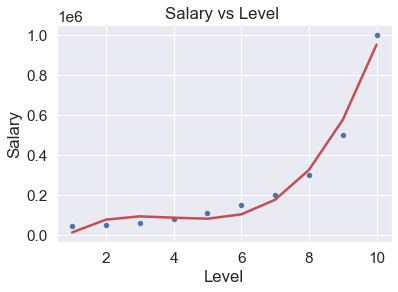

In [56]:
fit_function = np.poly1d(fit)

sns.scatterplot(x=df.Level, y=df.Salary)
sns.lineplot(x=df.Level, y=fit_function(x), color='r', linewidth=2.5)
plt.title('Salary vs Level ')

In [57]:
print("r_square score (train): %.4f" % r2_score(df.Salary,fit_function(x)))

r_square score (train): 0.9812


### Fourth degree polonomy

In [58]:
fit = np.polyfit(x, df.Salary, deg=4)
print ("1st degree coefficent : " + str(fit[0]/1000000))
print ("2nd degree coefficent : " + str(fit[1]/1000000))
print ("3rd degree coefficent : " + str(fit[2]/1000000))
print ("4th degree coefficent : " + str(fit[3]/1000000))
print ("Intercept : " + str(fit[4]/1000000))

1st degree coefficent : 0.0008901515151515106
2nd degree coefficent : -0.011902680652680577
3rd degree coefficent : 0.053716491841491444
4th degree coefficent : -0.06430069930069858
Intercept : 0.05335664335664328


Text(0.5, 1.0, 'Salary vs Level ')

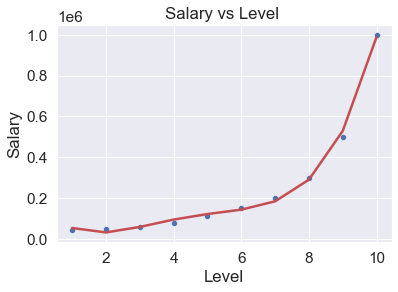

In [59]:
fit_function = np.poly1d(fit)

sns.scatterplot(x=df.Level, y=df.Salary)
sns.lineplot(x=df.Level, y=fit_function(x), color='r', linewidth=2.5)
plt.title('Salary vs Level ')

In [60]:
print("r_square score (train): %.4f" % r2_score(df.Salary,fit_function(x)))

r_square score (train): 0.9974
